In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from keras import layers, optimizers, losses, metrics, Model, models
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

/home/aveek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

G = nx.read_gml('datasets/verified.gml')

In [3]:
# nx.draw(G, with_labels=True, font_weight='bold')

In [4]:
G.number_of_nodes(), G.number_of_edges()

(2901, 148998)

In [5]:
# for line in nx.generate_edgelist(G):
#   print(line) 

In [6]:
# nx.write_edgelist(sub_g, "verified_edgelist.txt")

In [7]:
# gr = nx.read_edgelist("verified_edgelist.txt")

In [8]:
# !wget -c "https://www.dropbox.com/s/8isf9jcvl4dh1jw/vectors.csv"

In [9]:

df = pd.read_csv("datasets/verified_features_all_300k.csv")


In [10]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,1172796973,PTorresTV,548,1117,25,12136,0,0.0,0.0,0.312530,...,0.002391,0.021099,0.001657,0.001920,0.003702,0.000585,0.002335,0.002460,0.007839,0.011049
1,1070586199,EOnlineUK,353,102733,316,60989,0,0.0,0.0,0.301738,...,0.002308,0.021205,0.002619,0.002023,0.005247,0.000557,0.002802,0.002584,0.009525,0.013514
2,25589776,people,1751,7565880,33588,267090,1,0.0,0.0,0.324708,...,0.002769,0.032744,0.000474,0.001301,0.002765,0.000771,0.004536,0.005398,0.009638,0.008561
3,1367531,FoxNews,398,18416786,65345,418052,0,0.0,0.0,0.214538,...,0.002891,0.004289,0.001988,0.001589,0.001920,0.000191,0.003285,0.004726,0.002932,0.018821
4,20012204,usweekly,1177,2181224,11975,188328,1,0.9,0.5,0.264836,...,0.000750,0.035524,0.000372,0.002707,0.002477,0.000550,0.005693,0.001944,0.007702,0.008623


In [11]:
# intersected_df = pd.merge(df, 
#                           df_feat[['name', 'listed_count', 'statuses_count', 'desc_subjectivity', 'desc_polarity']]
#                           , how='inner')

In [12]:
# intersected_df.info()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2902 entries, 0 to 2901
Columns: 205 entries, uid to musical_empath
dtypes: float64(198), int64(6), object(1)
memory usage: 4.5+ MB


In [14]:
# df = intersected_df

In [15]:
# df = df[df['uid'] != 936040869878042624]

In [16]:
names = list(df['name'].values)

In [17]:
sub_g = G.subgraph(names)

In [18]:
sub_g.number_of_nodes(), sub_g.number_of_edges()

(2900, 148998)

In [19]:
# df[]
nodes = list(sub_g.nodes())

df = df[df['name'].isin(nodes)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 2901
Columns: 205 entries, uid to musical_empath
dtypes: float64(198), int64(6), object(1)
memory usage: 4.6+ MB


In [20]:
df = df[df['name'].isin(nodes)]
names = list(df['name'].values)


In [21]:
names[0]

'PTorresTV'

In [22]:
# int(df['fake'][df['name'] == names[0]])
len(names)

2900

In [23]:
G.node['PTorresTV']

{'ffr': 2.0383,
 'file': 'verified.dat',
 'followers': 1117,
 'friends': 548,
 'image': '/home/aveek/twitter2/img/1172796973.jpg',
 'lfr': 0.2238,
 'listed': 25,
 'shape': 'triangle-up',
 'statuses': 12136,
 'type': 'friends',
 'userid': '1172796973'}

In [24]:
for n in names:
    G.node[n]['fake'] = int(df['fake'][df['name'] == n])

In [25]:
# G.node['PTorresTV']
nx.write_gml(G, "datasets/verified_fake_labels.gml")

In [26]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', 
                                    standardize=True)

# pt = StandardScaler()

In [27]:
# values = df.drop(columns=['name', 'fake']).values
values = df.drop(columns=['name', 'fake', 'uid']).values

values_log = pt.fit_transform(values)

/home/aveek/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [28]:
df = df.reindex(columns=['fake'] + [ x for x in df.columns if x!='fake'])

In [29]:
# df[df.columns[3:]]
# df[df.columns[2:]]

In [30]:
# df[df.columns[2:]] = values_log
df[df.columns[3:]] = values_log
df.head()

,fake,uid,name,friends_count,followers_count,listed_count,statuses_count,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,0,1172796973,PTorresTV,-0.581919,0.0,-2.234139,-1.296596,-0.914136,-0.427085,0.254067,...,0.406367,0.763588,3.025715,1.836441,0.862621,3.076810,-0.095552,0.513257,1.223009,0.979839
1,0,1070586199,EOnlineUK,-0.874906,0.0,-0.443690,0.013101,-0.914136,-0.427085,0.190879,...,0.379360,0.768702,3.556915,1.903542,1.214578,2.984755,-0.002623,0.554156,1.410441,1.174976
2,1,25589776,people,0.368048,0.0,2.312629,1.419716,-0.914136,-0.427085,0.324428,...,0.524213,1.211943,1.225343,1.350129,0.594292,3.590871,0.308841,1.260611,1.421453,0.733738
3,0,1367531,FoxNews,-0.798181,0.0,2.652388,1.890891,-0.914136,-0.427085,-0.350354,...,0.560568,-0.408646,3.264151,1.596237,0.308552,1.245072,0.089344,1.125324,0.329907,1.473822
4,1,20012204,usweekly,0.011520,0.0,1.761383,1.067187,1.608799,1.562750,-0.031281,...,-0.209424,1.291108,0.956071,2.268944,0.501842,2.960290,0.490076,0.331768,1.205752,0.740579


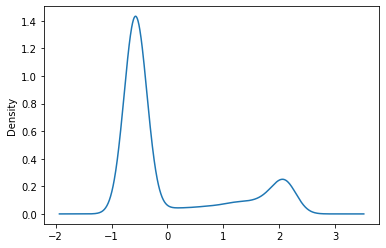

In [31]:
ax = plt.gca()

df['money_empath'].plot.kde()

plt.show()


In [32]:
df.index = df.index.map(str)
df = df.set_index('name')

In [33]:
df.index.names = [None]

In [34]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2900 entries, PTorresTV to LA_Beth
Columns: 204 entries, fake to musical_empath
dtypes: float64(202), int64(2)
memory usage: 4.5+ MB
None


In [35]:
# user_features
# train_data

In [36]:
df = df.astype({'fake': int})

In [37]:
user_features = df.drop(columns=['fake', 'uid'])
# user_features = df.drop(columns=['fake'])

user_target = df['fake']

In [38]:
train_data, test_data, train_targets, test_targets = train_test_split(user_features,
                                         user_target,
                                         test_size=0.2,
                                         random_state=1)

train_targets= train_targets.values.reshape((-1,1))
test_targets= test_targets.values.reshape((-1,1))


train_targets.shape, test_targets.shape, train_data.shape, test_data.shape

((2320, 1), (580, 1), (2320, 202), (580, 202))

In [39]:
stg = sg.StellarGraph(sub_g, node_features=df.drop(columns=['fake', 'uid']))

In [80]:
model_type = 'graphsage'    # Can be either gcn, gat, or graphsage


In [81]:

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 50; 
    num_samples = [20, 10]
    epochs = 30
    
    generator = GraphSAGENodeGenerator(stg, batch_size, num_samples)
    train_gen = generator.flow(train_data.index, 
                               train_targets, 
                               shuffle=True)
    
    base_model = GraphSAGE(
        layer_sizes=[32, 32],
        generator=train_gen,
        bias=True,
        dropout=0.5,
    )
    x_inp, x_out = base_model.default_model(flatten_output=True)
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
    
elif model_type == "gcn":
    # For GCN model
    epochs = 20 
    
    generator = FullBatchNodeGenerator(stg, method="gcn", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets, )
    
    base_model = GCN(
        layer_sizes=[32, 16],
        generator = generator,
        bias=True,
        dropout=0.5,
        activations=["elu", "elu"]
    )
    x_inp, x_out = base_model.node_model()
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
    
elif model_type == "gat":
    # For GAT model
    layer_sizes = [8, 1]
    attention_heads = 8
    epochs = 20
    
    generator = FullBatchNodeGenerator(stg, method="gat", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets,)
    
    base_model = GAT(
        layer_sizes=layer_sizes,
        attn_heads=attention_heads,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        activations=["elu", "sigmoid"],
        normalize=None,
    )
    x_inp, prediction = base_model.node_model()

In [82]:

model = Model(inputs=x_inp, outputs=prediction)

In [83]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [84]:
test_gen = generator.flow(test_data.index, test_targets)

In [85]:
history = model.fit_generator(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    verbose=1,
#     shuffle=False,
)

Epoch 1/30
47/47 [==============================] - 5s 109ms/step - loss: 0.6646 - acc: 0.5926 - val_loss: 0.6049 - val_acc: 0.6914
Epoch 2/30
47/47 [==============================] - 4s 75ms/step - loss: 0.6047 - acc: 0.6847 - val_loss: 0.5764 - val_acc: 0.6983
Epoch 3/30
47/47 [==============================] - 4s 82ms/step - loss: 0.5930 - acc: 0.6957 - val_loss: 0.5626 - val_acc: 0.7155
Epoch 4/30
47/47 [==============================] - 3s 66ms/step - loss: 0.5760 - acc: 0.7105 - val_loss: 0.5665 - val_acc: 0.7086
Epoch 5/30
47/47 [==============================] - 3s 68ms/step - loss: 0.5642 - acc: 0.7247 - val_loss: 0.5679 - val_acc: 0.7172
Epoch 6/30
47/47 [==============================] - 4s 76ms/step - loss: 0.5600 - acc: 0.7257 - val_loss: 0.5669 - val_acc: 0.7190
Epoch 7/30
47/47 [==============================] - 4s 79ms/step - loss: 0.5656 - acc: 0.7134 - val_loss: 0.5630 - val_acc: 0.7121
Epoch 8/30
47/47 [==============================] - 4s 79ms/step - loss: 0.5521 - 

In [86]:

# test_metrics = model.evaluate_generator(test_gen)
# print("\nTest Set Metrics:")
# for name, val in zip(model.metrics_names, test_metrics):
#     print("\t{}: {:0.4f}".format(name, val))

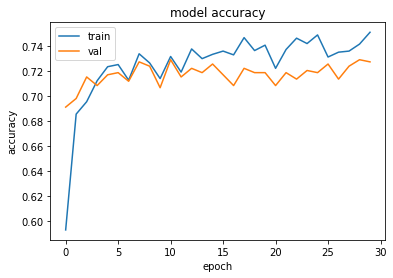

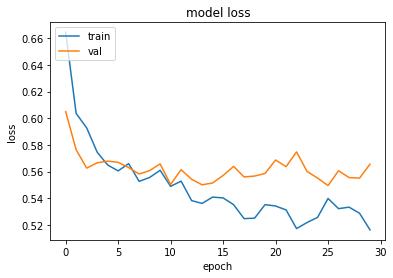

In [87]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [88]:

all_nodes = df.drop(columns=['fake','uid']).index
all_gen = generator.flow(all_nodes)

In [89]:
all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]

In [90]:
all_predictions.shape

(2900, 1)

In [91]:
# df.drop(columns=['fake'])

In [92]:
all_predictions_df = pd.DataFrame(all_predictions, 
                                  index=df.drop(columns=['fake','uid']).index)

In [93]:
test_preds = all_predictions_df.loc[test_data.index, :]

In [94]:

test_preds.head()

,0
949ThePoint,0.081410
BBCBreaking,0.283980
987fm,0.872675
hburgamerican,0.095737
rachelsklar,0.798415


In [95]:
from numpy import isnan
test_predictions = test_preds.values
where_are_NaNs = isnan(test_predictions)
test_predictions[where_are_NaNs] = 0
test_predictions_class = ((test_predictions>=0.5)*1).flatten()
test_df = pd.DataFrame({"Predicted_score": test_predictions.flatten(), 
                        "Predicted_class": test_predictions_class, 
                        "True": test_targets[:,0]})
roc_auc = metrics.roc_auc_score(test_df['True'].values, 
                                test_df['Predicted_score'].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.7756004756242567


In [96]:
# test_df['Predicted_score'].values
# test_predictions_class
# test_df['True'].values

In [97]:

pd.crosstab(test_df['True'], test_df['Predicted_class'])

Predicted_class,0,1
True,,
0,161,129
1,41,249


In [98]:

print('Accuracy: %f' % accuracy_score(test_df['True'], test_df['Predicted_class']))
print('Precision: %f' % precision_score(test_df['True'], test_df['Predicted_class']))
print('Recall: %f' % recall_score(test_df['True'], test_df['Predicted_class']))
print('F1 score: %f' % f1_score(test_df['True'], test_df['Predicted_class']))

# confusion matrix
# print(confusion_matrix(test_df['True'], test_df['Predicted_class']))

Accuracy: 0.706897
Precision: 0.658730
Recall: 0.858621
F1 score: 0.745509
